# Retrieval-Augmented Generation (RAG)
RAG is an approach that combines a retrieval mechanism with generative AI models to answer user queries. Here’s how it works:

**Retrieval:** The system first retrieves relevant information from a large knowledge base (like documents, databases, or embeddings) using similarity-based search techniques.

**Generation**: A generative language model then uses this retrieved information as context to generate a relevant and accurate response.

Why Use RAG? RAG improves accuracy by grounding responses in specific, relevant information, which makes it ideal for applications requiring precise answers, such as searching financial documents, legal files, or reports.

#  team GRN
 Ghaliah, Rawan, and Najla

 the link to the data and all files : https://drive.google.com/drive/folders/1igEymeZlm7PbnQXvAuchfMvjvroZyKWE?usp=sharing

In [ ]:
!pip install -U langchain-community
!pip install pypdf
!pip install tiktoken
!pip install langchain transformers faiss-cpu
!pip install deep-translator
!pip install langdetect
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=1f1485711c70d8d1b488035d3178a0deb3e8c97901a8c2ab5355b8aa3d70239b

In [ ]:
# Import necessary libraries
import os
from langchain.llms import OpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.agents.agent_toolkits import VectorStoreToolkit, VectorStoreInfo
from langchain.agents.agent_toolkits import create_vectorstore_agent
from langdetect import detect
from deep_translator import GoogleTranslator  # Import GoogleTranslator from deep-translator


In [ ]:
# Set OpenAI API Key
os.environ['OPENAI_API_KEY'] = os.getenv('API_KEY')

In [ ]:
logos = {
    "Elm": "elm.png",   # Replace with actual file path or URL
    "Aramco": "aramco.png",
    "SOLUTIONS": "SOLUTIONS.png",
}

# Sidebar for company selection
st.sidebar.title("Company Selection")

# Display each company with its logo
company = st.sidebar.radio(
    "Please choose a company:",
    ["Elm", "Aramco", "SOLUTIONS"],
    format_func=lambda x: f"{x}  "
)

st.sidebar.image(logos[company], use_container_width=True)

# Map selected company to file paths
file_paths = {
    "Elm": "eng.pdf",
    "Aramco": "aramco.pdf",
    "SOLUTIONS": "SOLUTIONS.pdf"
}


**To run the Streamlit app locally, follow these steps:**

Download the Project Folder
Download or clone the entire project folder onto your computer.

Open the Folder in VS Code
Open the folder in Visual Studio Code (VS Code) or any code editor of your choice.
Run the Streamlit App
Use the following command in the terminal to start the Streamlit app:
streamlit run datathon.py

In [ ]:
try:
    # Load PDF document
    doc_info = {
        'path': file_paths[company],
        'name': 'multilingual_doc',
        'description': f"Annual report document for {company}"
    }

    loader = PyPDFLoader(doc_info['path'])
    pages = loader.load()
    raw_text = ''.join([page.page_content for page in pages])

    # Text splitting
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    chunks = text_splitter.split_text(raw_text)
    documents = [Document(page_content=chunk, metadata={'source': f"Page {i+1}"}) for i, chunk in enumerate(chunks)]

    # Create FAISS index
    embedding_model = OpenAIEmbeddings()
    faiss_index = FAISS.from_documents(documents, embedding_model)

    # VectorStore info and toolkit setup
    vectorstore_info = VectorStoreInfo(name=doc_info['name'], description=doc_info['description'], vectorstore=faiss_index)
    llm = OpenAI(temperature=0)
    toolkit = VectorStoreToolkit(vectorstore_info=vectorstore_info, llm=llm)

    # Create the retrieval agent
    retrieval_agent = create_vectorstore_agent(llm=llm, toolkit=toolkit, verbose=True)

    # Main UI setup
    st.title("RAG Chatbot")
    st.markdown("### Ask questions about the annual reports")
    st.markdown(f"**Selected Company:** {company}")

    # User input
    query = st.text_input("Type your question here:")

    # Respond to user input
    if query:
        language = detect(query)
        with st.spinner("Retrieving answer..."):
            response = retrieval_agent.run(query)
            if language == 'ar':
                response = GoogleTranslator(source='en', target='ar').translate(response)
            st.markdown("### Answer:")
            st.write(response)

except Exception as e:
    st.write("Sorry, an error occurred.")

# Add footer
st.sidebar.markdown("---")
st.sidebar.markdown("Developed by GRN")


OUTPUT
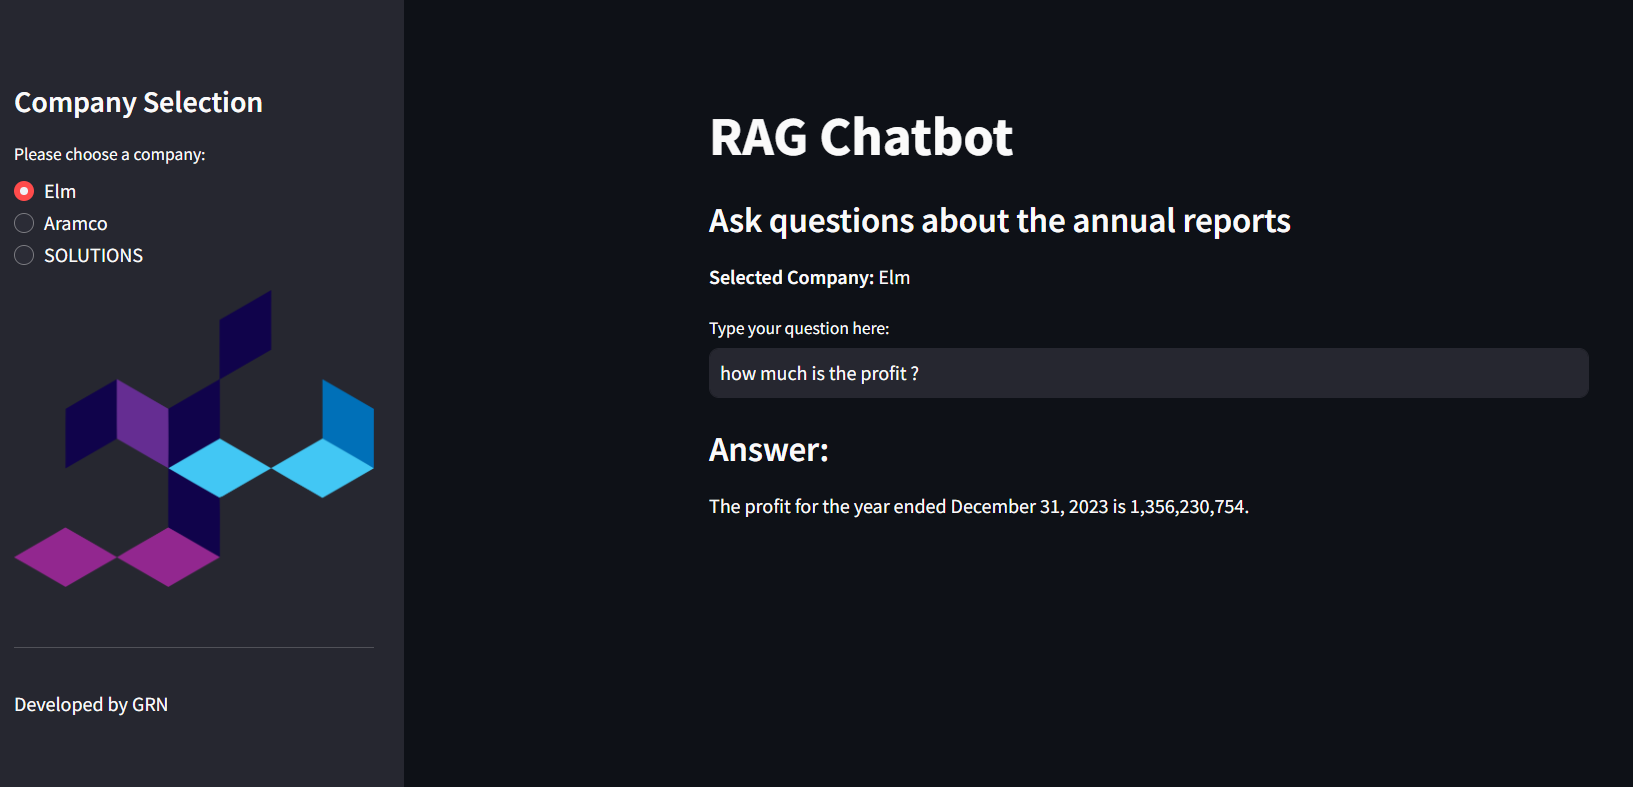



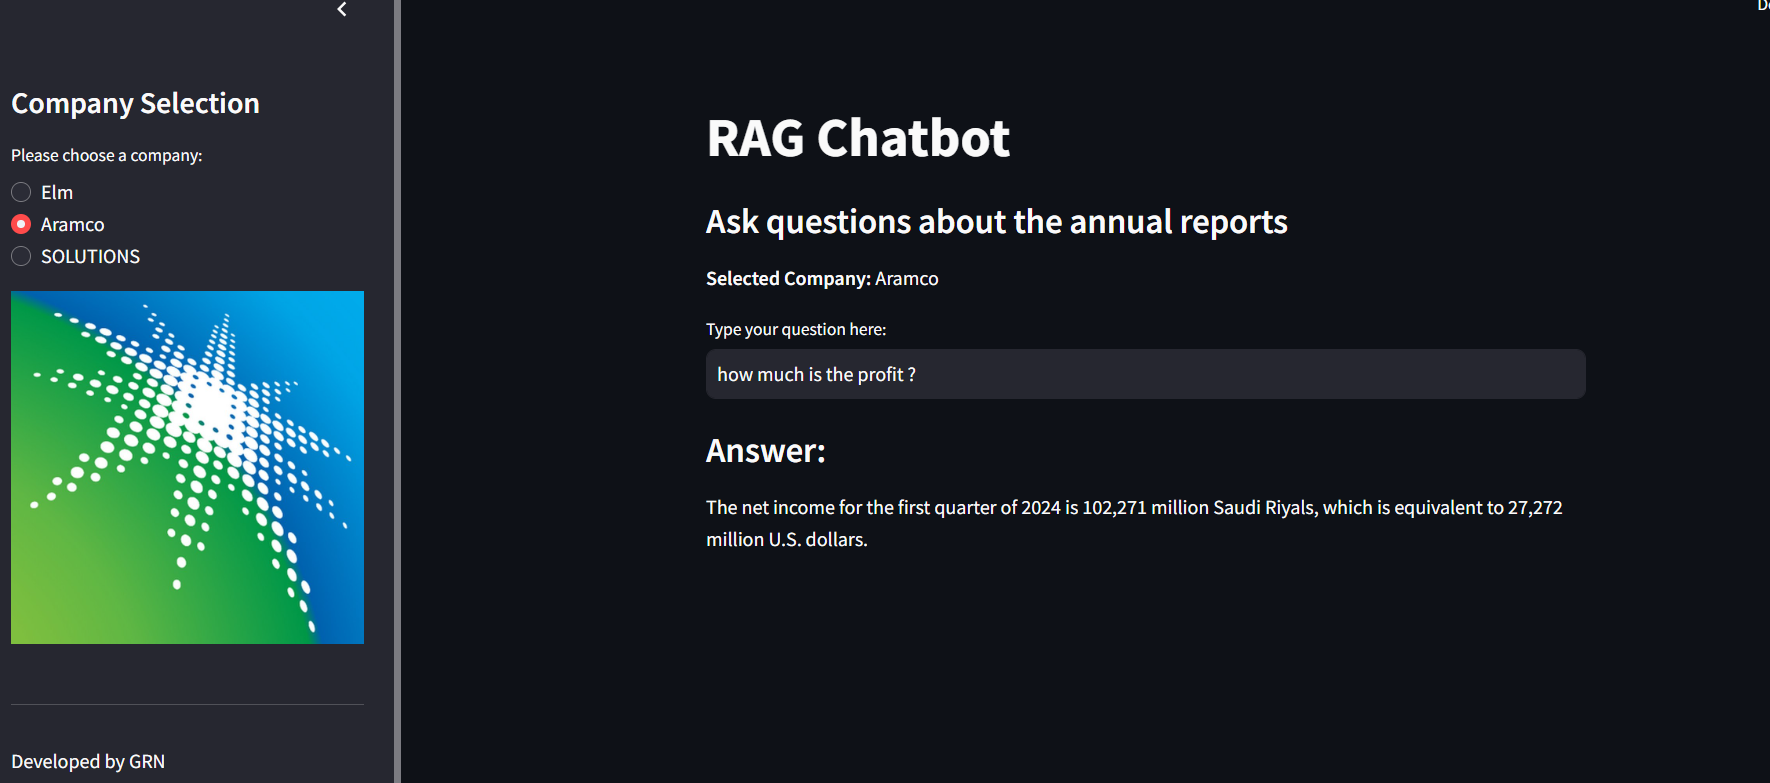